In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
from tqdm import tqdm
import math

# --- 1. Setup ---
sys.path.append('.')
from sudoku import SudokuDataset, SudokuMDM, MaskSchedule

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# --- 2. Load Base Model ---
base_model = SudokuMDM(vocab_size=10, d_model=384, nhead=12, num_layers=4, dim_feedforward=512, dropout=0.1).to(device)

try:
    ckpt = torch.load('./checkpoints/sudoku_mdm_best.pt', map_location=device)
    base_model.load_state_dict(ckpt['model_state_dict'])
    base_model.eval()
    print("Loaded Base Model.")
except FileNotFoundError:
    print("Warning: Base Checkpoint not found! Using random weights.")

# --- 3. Log-MI Predictor Class ---
class LogMIPredictor(nn.Module):
    def __init__(self, mdm_model, hidden_dim=128, dropout=0.1):
        super().__init__()
        self.mdm_dim = mdm_model.d_model
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=4, dim_feedforward=256, dropout=dropout, batch_first=True)
        self.adapter = nn.Sequential(
            nn.Linear(self.mdm_dim, hidden_dim),
            nn.GELU(),
            nn.TransformerEncoder(encoder_layer, num_layers=1)
        )
        self.query_proj = nn.Linear(hidden_dim, hidden_dim)
        self.key_proj = nn.Linear(hidden_dim, hidden_dim)
        self.output_head = nn.Linear(hidden_dim, 1)

    def forward(self, mdm_embeddings):
        h = self.adapter(mdm_embeddings) 
        q = self.query_proj(h) # [B, 81, H]
        k = self.key_proj(h)   # [B, 81, H]
        
        # Interaction: [B, 81, 1, H] * [B, 1, 81, H] -> [B, 81, 81, H]
        interaction = q.unsqueeze(2) * k.unsqueeze(1)
        out = self.output_head(interaction)
        return out.squeeze(-1)

# --- 4. Target Generation (Oracle Log-MI) ---
def get_log_mi_targets(model, puzzles, solutions, num_pairs=200):
    B = puzzles.shape[0]
    EPSILON = 1e-9 
    
    with torch.no_grad():
        base_logits = model(puzzles)
        base_probs = F.softmax(base_logits, dim=-1)
        base_H = -torch.sum(base_probs * torch.log(base_probs + EPSILON), dim=-1)
        
    queries = [] 
    is_masked = (puzzles == 0)
    
    for b in range(B):
        m_idx = is_masked[b].nonzero(as_tuple=True)[0]
        if len(m_idx) < 2: continue
        curr_num_pairs = min(num_pairs, len(m_idx)*(len(m_idx)-1))
        idxs = torch.randint(0, len(m_idx), (curr_num_pairs, 2), device=device)
        srcs, tgts = m_idx[idxs[:,0]], m_idx[idxs[:,1]]
        valid = (srcs != tgts)
        for i, j in zip(srcs[valid], tgts[valid]): 
            queries.append((b, i.item(), j.item()))

    if not queries: return None, None

    unique_src = {}
    for b, i, j in queries: 
        if (b, i) not in unique_src: unique_src[(b,i)] = []
        unique_src[(b,i)].append(j)
        
    hypo_puzzles, meta = [], []
    for (b, i), tgts in unique_src.items():
        token = solutions[b, i].item()
        p_new = puzzles[b].clone(); p_new[i] = token
        hypo_puzzles.append(p_new); meta.append({'b':b, 'i':i, 'tgts':tgts})
        
    hypo_batch = torch.stack(hypo_puzzles)
    results = {}
    
    with torch.no_grad():
        for start in range(0, len(hypo_batch), 128):
            end = min(start+128, len(hypo_batch))
            batch = hypo_batch[start:end]
            probs_cond = F.softmax(model(batch), -1)
            H_cond_all = -torch.sum(probs_cond * torch.log(probs_cond+EPSILON), -1)
            
            for k in range(end-start):
                m = meta[start+k]
                mi = base_H[m['b']] - H_cond_all[k]
                mi = torch.clamp(mi, min=0)
                log_mi = torch.log(mi + EPSILON)
                for j in m['tgts']: results[(m['b'], m['i'], j)] = log_mi[j].item()

    indices = torch.tensor(queries, dtype=torch.long, device=device)
    vals = torch.tensor([results[q] for q in queries], dtype=torch.float, device=device)
    return indices, vals

# --- 5. Training (Interruptible) ---
def train_log_predictor(predictor, base_model, dataset, epochs=10, save_path='sudoku_mi_predictor.pt'):
    """
    Trains the passed 'predictor' model.
    Catches KeyboardInterrupt to allow safe stopping.
    """
    if os.path.exists(save_path):
        print(f"Resuming from {save_path}...")
        predictor.load_state_dict(torch.load(save_path, map_location=device))
        
    optimizer = torch.optim.AdamW(predictor.parameters(), lr=1e-4, weight_decay=1e-2)
    loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
    mask_sched = MaskSchedule('linear', 40)
    
    print("Training Log-MI Predictor... (Press Stop/Ctrl+C to finish early)")
    predictor.train()
    
    SIGNAL_THRESHOLD = -10.0 
    TARGET_FLOOR = -14.0
    
    try:
        for epoch in range(epochs):
            pbar = tqdm(loader, desc=f"Ep {epoch+1}")
            avg_loss = 0
            
            for i, (puzzles, solutions) in enumerate(pbar):
                solutions = solutions.to(device)
                puzzles, _ = mask_sched.apply_mask(solutions.clone(), mask_sched.get_mask_ratio(np.random.randint(5,45)))
                
                indices, targets = get_log_mi_targets(base_model, puzzles, solutions, num_pairs=256)
                if indices is None: continue
                
                targets = torch.clamp(targets, min=TARGET_FLOOR)
                
                with torch.no_grad():
                    emb = base_model.embedding(puzzles)
                    features = base_model.transformer(base_model.pos_encoder(emb))
                
                pred_full = predictor(features)
                preds = pred_full[indices[:,0], indices[:,1], indices[:,2]]
                
                # Weighted SmoothL1 Loss
                loss_fn = nn.SmoothL1Loss(reduction='none')
                raw_loss = loss_fn(preds, targets)
                weights = torch.ones_like(targets)
                weights[targets > SIGNAL_THRESHOLD] = 5.0
                loss = (weights * raw_loss).mean()
                
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(predictor.parameters(), 1.0)
                optimizer.step()
                
                current_val = loss.item()
                avg_loss = current_val if i == 0 else 0.9 * avg_loss + 0.1 * current_val
                pbar.set_postfix({'loss (avg)': f"{avg_loss:.4f}", 'curr': f"{current_val:.2f}"})
            
            torch.save(predictor.state_dict(), save_path)
            
    except KeyboardInterrupt:
        print("\nTraining interrupted by user. Saving current state...")
        torch.save(predictor.state_dict(), save_path)
        print("Model saved.")
        
    return predictor

# --- 6. Visualization (Corrected Orientation) ---
def visualize_log_results(model, predictor, dataset, idx=2005):
    print(f"Visualizing Puzzle {idx}...")
    model.eval(); predictor.eval()
    
    puzzle, solution = dataset[idx]
    puzzle = puzzle.unsqueeze(0).to(device); solution = solution.unsqueeze(0).to(device)
    
    mask = (puzzle==0)[0] 
    masked_indices = mask.nonzero(as_tuple=True)[0]
    if len(masked_indices) == 0:
        print("Puzzle has no masked values.")
        return
        
    src = masked_indices[np.random.randint(0,len(masked_indices))].item()
    r, c = divmod(src, 9)
    print(f"Source Cell: Row {r}, Col {c}")
    
    # 1. Prediction
    with torch.no_grad():
        emb = model.embedding(puzzle)
        feats = model.transformer(model.pos_encoder(emb))
        pred_log = predictor(feats)[0, src]
        pred_map = torch.exp(pred_log).cpu().numpy().reshape(9,9)
        
    # 2. GT (Oracle)
    with torch.no_grad():
        logits = model(puzzle)
        probs = F.softmax(logits, -1)
        H_initial = -torch.sum(probs * torch.log(probs + 1e-9), -1)[0]
        
        p_hypo = puzzle.clone(); p_hypo[0, src] = solution[0, src]
        probs_cond = F.softmax(model(p_hypo), dim=-1)
        H_cond = -torch.sum(probs_cond * torch.log(probs_cond + 1e-9), -1)[0]
        gt_map = (H_initial - H_cond).clamp(min=0).cpu().numpy().reshape(9,9)

    # 3. Masking
    mask_np = mask.cpu().numpy().reshape(9,9)
    gt_map[~mask_np] = 0.0; gt_map.reshape(-1)[src] = 0.0
    pred_map[~mask_np] = 0.0; pred_map.reshape(-1)[src] = 0.0

    # 4. Plot (No Inversion - Standard Matrix View)
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    # gt_map = gt_map / gt_map.max()
    # pred_map = pred_map / pred_map.max()
    vmax = 1#gt_map.max() if gt_map.max() > 0 else 1.0
    
    for i in range(puzzle.shape[1]):
        print(str(puzzle[0][i].item()) + " ", end="")
        if (i + 1) % 9 == 0:
            print()

    # Ground Truth
    sns.heatmap(gt_map, ax=ax[0], cmap='magma', vmin=0, vmax=gt_map.max(), square=True)
    ax[0].set_title("GT MI (Oracle)")
    ax[0].add_patch(plt.Rectangle((c, r), 1, 1, fill=False, edgecolor='cyan', lw=3))
    # Note: No ax[0].invert_yaxis()!
    
    # Prediction
    sns.heatmap(pred_map, ax=ax[1], cmap='magma', vmin=0, vmax=pred_map.max(), square=True)
    ax[1].set_title("Pred MI (Exp(LogPred))")
    ax[1].add_patch(plt.Rectangle((c, r), 1, 1, fill=False, edgecolor='cyan', lw=3))

    plt.tight_layout()
    plt.show()


Loaded Base Model.


/home/jaisharma/miniconda3/envs/sudoku/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Visualizing Puzzle 2005...
Source Cell: Row 0, Col 8
2 0 6 0 3 0 0 0 0 
0 0 0 1 0 9 0 0 0 
3 0 0 7 4 0 8 1 0 
8 0 0 0 0 0 0 9 7 
9 0 0 2 0 1 4 0 5 
0 3 1 0 0 0 0 6 8 
4 5 0 0 7 0 0 0 0 
0 7 0 3 6 0 0 2 9 
0 2 0 8 0 5 0 0 3 


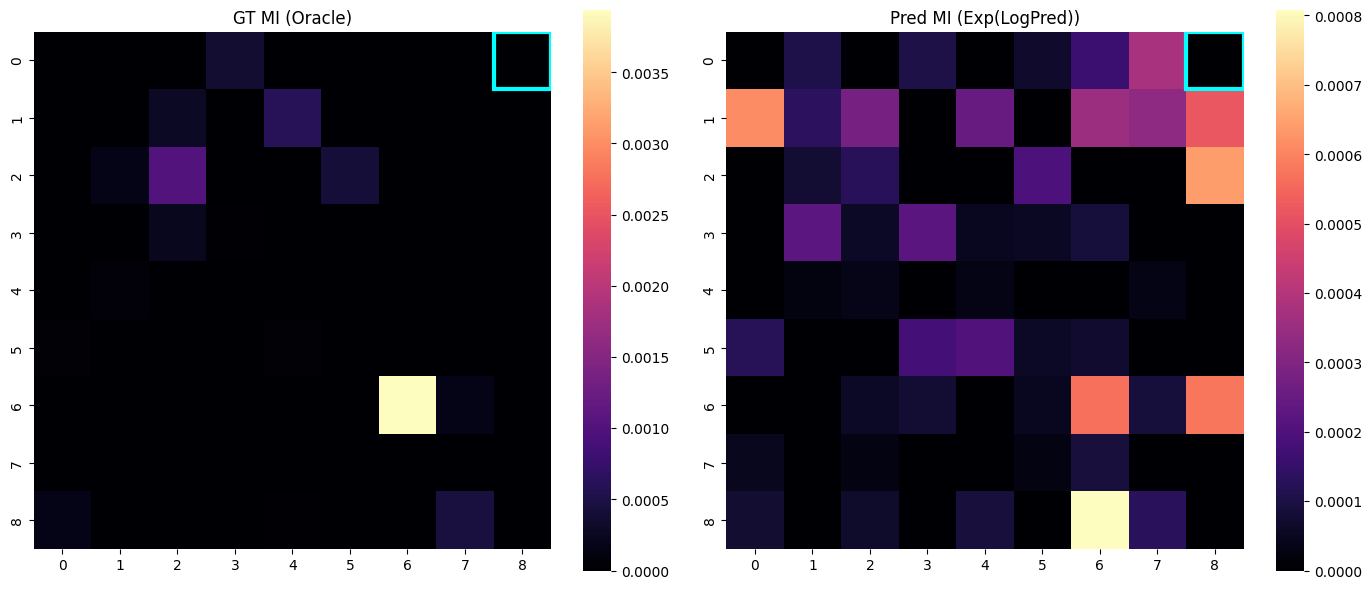

In [19]:
visualize_log_results(base_model, mi_predictor, full_dataset, idx=2005)

Searching 100 puzzles for a High-MI example...

Found Strong Signal!
Puzzle Index: 99
Max Log Pred: 0.43
Visualizing Puzzle 99...
Source Cell: Row 0, Col 0
0 4 0 0 3 8 5 0 0 
9 0 5 0 0 0 0 0 0 
0 0 0 0 1 0 4 6 0 
0 0 1 6 5 0 0 4 3 
0 0 0 7 0 0 9 0 1 
0 8 2 3 0 0 0 5 0 
8 3 0 1 0 0 0 7 4 
2 7 6 0 0 0 0 9 0 
0 0 0 9 6 0 0 0 2 


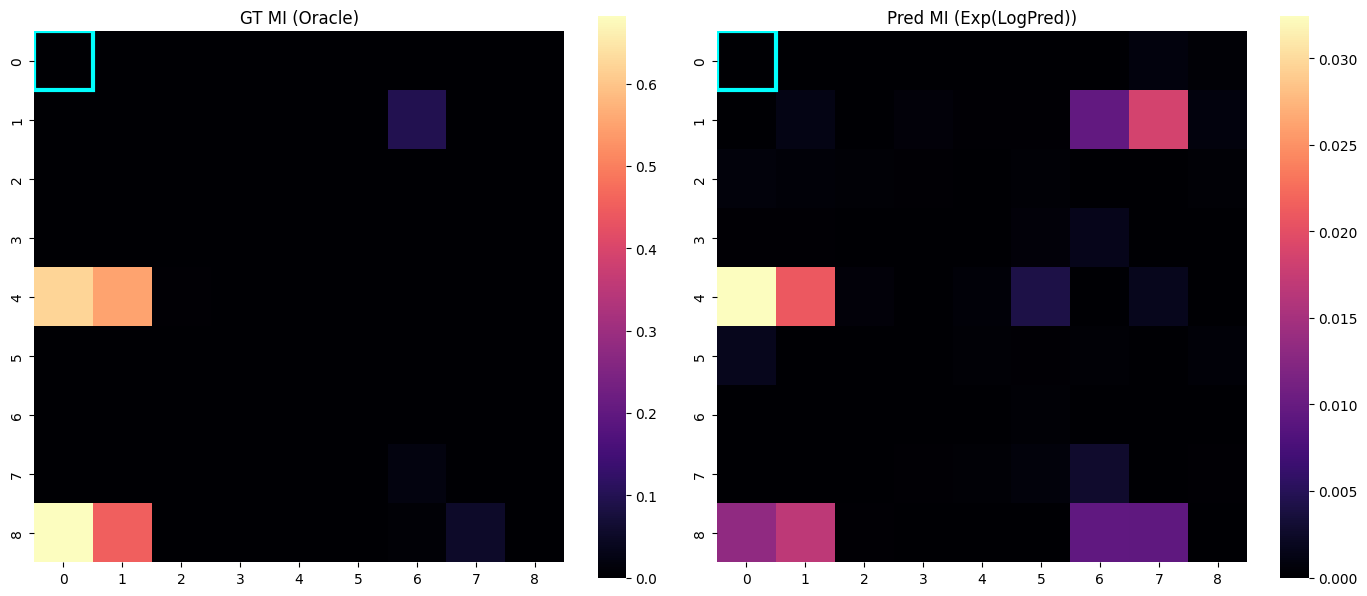

In [15]:
def find_and_visualize_high_mi(model, predictor, dataset, search_limit=100):
    print(f"Searching {search_limit} puzzles for a High-MI example...")
    model.eval(); predictor.eval()
    
    best_val = -1
    best_idx = -1
    best_src = -1
    
    # Search loop
    for i in range(search_limit):
        puzzle, _ = dataset[i]
        puzzle = puzzle.unsqueeze(0).to(device)
        mask = (puzzle==0)[0]
        masked_indices = mask.nonzero(as_tuple=True)[0]
        
        if len(masked_indices) < 5: continue
            
        with torch.no_grad():
            emb = model.embedding(puzzle)
            feats = model.transformer(model.pos_encoder(emb))
            # Get max predicted Log MI for this puzzle
            pred_logs = predictor(feats) # [1, 81, 81]
            
            # We only care about masked-to-masked connections
            # Let's just check the max value in the prediction matrix
            curr_max = pred_logs.max().item()
            
            if curr_max > best_val:
                best_val = curr_max
                best_idx = i
                # Find which cell caused this max
                best_src = (pred_logs == pred_logs.max()).nonzero(as_tuple=True)[1][0].item()
    
    print(f"\nFound Strong Signal!")
    print(f"Puzzle Index: {best_idx}")
    print(f"Max Log Pred: {best_val:.2f}")
    
    # Visualize this specific winner
    visualize_log_results(model, predictor, dataset, idx=best_idx)

# Run the search
find_and_visualize_high_mi(base_model, mi_predictor, full_dataset)

In [ ]:
# --- 7. Execution ---
if __name__ == "__main__":
    # Setup Data
    full_dataset = SudokuDataset('./data/sudoku.csv')
    train_subset = torch.utils.data.Subset(full_dataset, range(min(5000, len(full_dataset))))
    
    # 1. Initialize Model
    mi_predictor = LogMIPredictor(base_model).to(device)
    
    # 2. Train (Interruptible - Press Stop button in notebook when satisfied)
    train_log_predictor(mi_predictor, base_model, train_subset, epochs=15)
    
    # 3. Visualize
    visualize_log_results(base_model, mi_predictor, full_dataset, idx=2005)

Loading Sudoku from CSV: ./data/sudoku.csv (start=0, n=10000)
✓ Loaded 10000 puzzles from CSV: ./data/sudoku.csv
Resuming from sudoku_mi_predictor.pt...
Training Log-MI Predictor... (Press Stop/Ctrl+C to finish early)


Ep 1:   3%|▎         | 4/157 [00:01<00:46,  3.30it/s, loss (avg)=3.2206, curr=3.22]

In [17]:
# Visualize
visualize_log_results(base_model, mi_predictor, full_dataset, idx=2005)

NameError: name 'mi_predictor' is not defined

In [45]:
# Run
full_dataset = SudokuDataset('./data/sudoku.csv')
ts = torch.utils.data.Subset(full_dataset, range(2000))
mi_pred = train_scaled_predictor(base_model, ts, epochs=10)

Loading Sudoku from CSV: ./data/sudoku.csv (start=0, n=10000)
✓ Loaded 10000 puzzles from CSV: ./data/sudoku.csv
Training Scaled Predictor (MI * 100)...


Ep 2:  12%|█▎        | 4/32 [00:02<00:18,  1.54it/s, loss=747]    


KeyboardInterrupt: 

Source: (0,1)


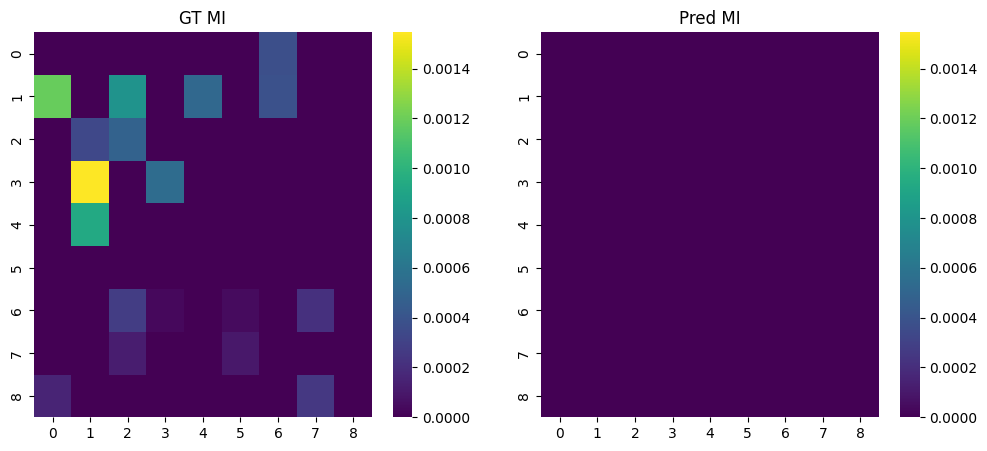

In [43]:
# Visualize
visualize_scaled(base_model, mi_pred, full_dataset)

Using device: cuda


/home/jaisharma/miniconda3/envs/sudoku/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Loaded base SudokuMDM model.
Loading Sudoku from CSV: ./data/sudoku.csv
Loaded 10000 puzzles from CSV
Training Neural Estimator on Top-1 Impact...


Epoch 5/5: 100%|██████████| 63/63 [00:09<00:00,  6.42it/s, loss=8.29e-5] 


Generating Top-1 GT vs Prediction for puzzle 2005...
Inspecting dependencies for Cell (0, 1)...


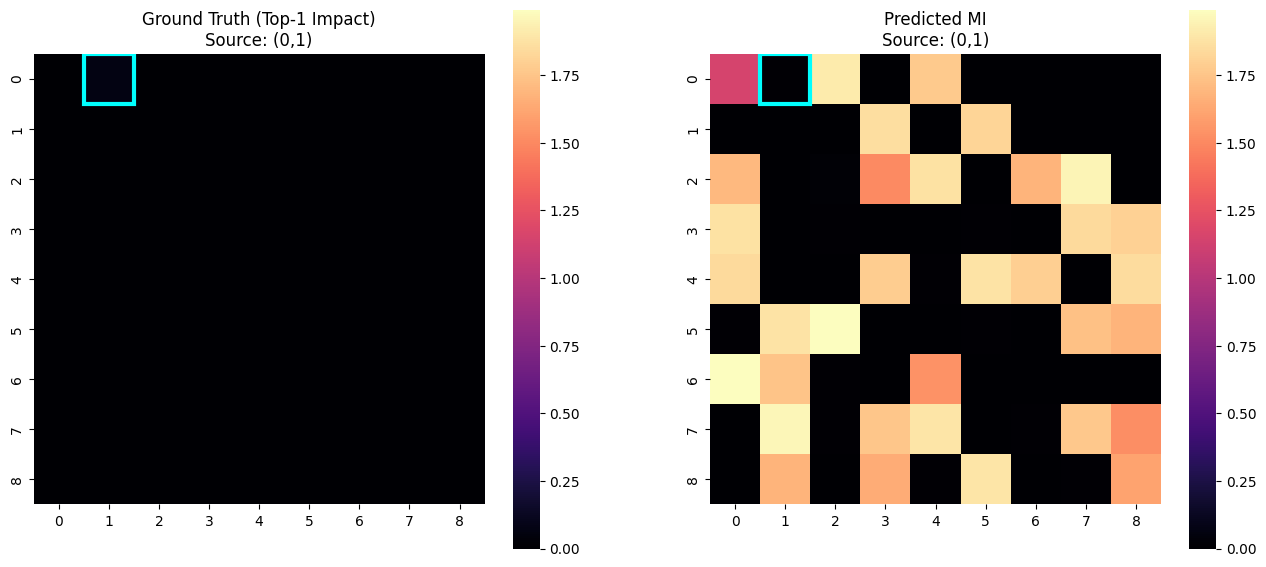

In [ ]:
# --- 7. Execution ---
full_dataset = SudokuDataset('./data/sudoku.csv') 
train_size = 2000
train_set = torch.utils.data.Subset(full_dataset, range(train_size))

# Retrain with new logic
ce_predictor = train_ce_predictor(base_model, train_set, epochs=5)

# Verify
visualize_ground_truth_vs_pred(base_model, ce_predictor, full_dataset)

Generating Top-1 GT vs Prediction for puzzle 2005...
Inspecting dependencies for Cell (0, 1)...


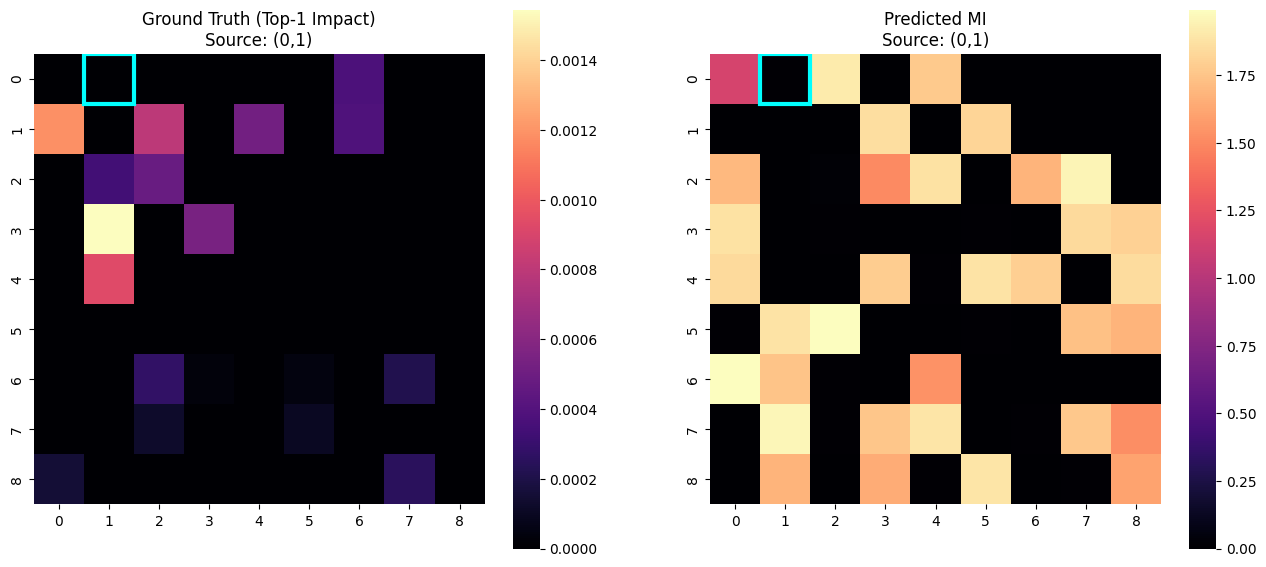

In [6]:
visualize_ground_truth_vs_pred(base_model, ce_predictor, full_dataset)